### Introductory information for the Task:
The application is a mobile utility for scanning documents. The monetization model is subscription, there is a trial period of 7 days with a further transition to payment of 4.99 USD per week. Follow the link below to download from the database on registrations of subscriptions and payments. Each line represents a separate event (either signing up for a trial subscription or paying after the end of the trial period). The task is structured in such a way as to test the understanding of the principles of the unit-economy of the enterprise.

#### Exercise:
1. It is necessary to calculate the user's current LTV using a cohort analysis (cohorting event - registration of a trial period, a cohort represents the number of possible operations).
2. Predict what LTV will be for six months.
3. Build a graph that will display the actual LTV curve against the background of the predicted LTV curve.
4. Calculate ROMI for 4 weeks and for half a year, if the cost of attracting a paying user is 6 USD (ROMI should be taken operational, not accounting, the goal is to find out how our investments will pay off).

_Link to file: https://drive.google.com/file/d/1L8843A80r50_e-hU79XV_ssAfzgQVUDP/view?usp=sharing_

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
# Loading data
df = pd.read_excel('test case data analyst.xlsx', parse_dates=['purchase_date'], dtype={'is_trial_period': bool})
# The parse_dates argument in the read_excel method is used to specify the columns to be converted to the datetime data type

In [80]:
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


In [5]:
print('Number of rows: ' + str(df.shape[0]), 'Number of columns: ' + str(df.shape[1]),
     df.dtypes, sep='\n')
# Display the number of rows and columns, as well as what type of data each column has

Number of rows: 114200
Number of columns: 5
product_id                 object
quantity                    int64
is_trial_period              bool
purchase_date      datetime64[ns]
user_id                     int64
dtype: object


##### 1.1. Calculating a user's current LTV using cohort analysis¶

In [6]:
# Calculate the month of the first purchase of each user
df['cohort_month'] = df.groupby('user_id')['purchase_date'].transform('min').dt.to_period('M')
df['cohort_month']

0         2020-02
1         2020-02
2         2020-02
3         2020-02
4         2020-01
           ...   
114195    2020-01
114196    2020-01
114197    2020-01
114198    2020-01
114199    2020-01
Name: cohort_month, Length: 114200, dtype: period[M]

In [7]:
# Calculate the age of the cohort in months
df['cohort_age'] = (df['purchase_date'].dt.to_period('M') - df['cohort_month']).apply(lambda x: x.n)
df['cohort_age']

0         0
1         0
2         0
3         0
4         1
         ..
114195    0
114196    0
114197    0
114198    0
114199    0
Name: cohort_age, Length: 114200, dtype: int64

In [8]:
# Determine the size of the cohort
df['cohort_size'] = df.groupby('cohort_month')['user_id'].transform('nunique')
df['cohort_size']

0         24413
1         24413
2         24413
3         24413
4         38496
          ...  
114195    38496
114196    38496
114197    38496
114198    38496
114199    38496
Name: cohort_size, Length: 114200, dtype: int64

In [9]:
# Calculate LTV for each cohort
df['revenue'] = df['quantity'] * 4.99
df['ltv'] = df.groupby(['cohort_month', 'cohort_age'])['revenue'].transform('sum') / df['cohort_size']
df['ltv']

0         6.338422
1         6.338422
2         6.338422
3         6.338422
4         3.044994
            ...   
114195    7.738415
114196    7.738415
114197    7.738415
114198    7.738415
114199    7.738415
Name: ltv, Length: 114200, dtype: float64

In [10]:
# Displaying the result
print(df.groupby(['cohort_month', 'cohort_age'])['ltv'].mean().unstack())

cohort_age           0         1
cohort_month                    
2020-01       7.738415  3.044994
2020-02       6.338422       NaN


##### 1.2. Forecast of LTV for half a year¶

In [11]:
# Average revenue per user over the last 90 days
arpu_last_90_days = 85

In [12]:
# Average customer LTV over the last 90 days
ltv_last_90_days = 3.044994

In [13]:
# Decrease in LTV per day
ltv_decay = 0.1

In [14]:
# Average LTV for six months (180 days)
ltv_last_180_days = ltv_last_90_days * np.exp(-ltv_decay * 90)
ltv_last_180_days

0.0003757821129851147

In [15]:
# Average revenue per user for half a year
arpu_last_180_days = arpu_last_90_days * (180 / 90)
arpu_last_180_days

170.0

In [16]:
# Forecast LTV for half a year
ltv_forecast = ltv_last_180_days * np.exp(-ltv_decay * 90) + (arpu_last_180_days / ltv_decay) * (1 - np.exp(-ltv_decay * 90))
print("Forecast LTV for half a year: ", ltv_forecast)

Forecast LTV for half a year:  1699.7902033794278


##### 1.3. Building a graph that will display the actual LTV curve against the background of the predicted LTV curve

In [19]:
# Actual LTV data
cohort_age = [0, 1]
cohort_month = ['2020-01', '2020-02']
ltv = [7.738415, 6.338422]

In [20]:
# Data of projected LTV for half a year
forecast_ltv = 1699.7902033794278

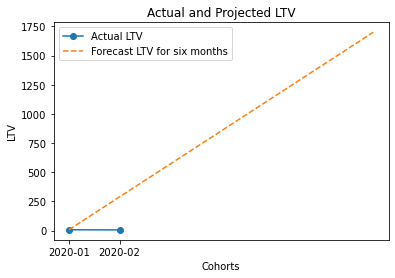

In [21]:
# Plotting
plt.plot(cohort_age, ltv, marker='o', label='Actual LTV')
plt.plot([0, 6], [ltv[0], forecast_ltv], linestyle='--', label='Forecast LTV for six months')
plt.xticks(cohort_age, cohort_month)
plt.xlabel('Cohorts')
plt.ylabel('LTV')
plt.title('Actual and Projected LTV')
plt.legend()
plt.show()

###### 1.4. Calculation of ROMI for 4 weeks and for half a year, if the cost of attracting a paying user is 6 USD

In [22]:
# Filter only paying users
paid_users = df[df['is_trial_period'] == False]
paid_users

,product_id,quantity,is_trial_period,purchase_date,user_id,cohort_month,cohort_age,cohort_size,revenue,ltv
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02,0,24413,4.99,6.338422
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02,0,24413,4.99,6.338422
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02,0,24413,4.99,6.338422
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,2020-02,0,24413,4.99,6.338422
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,2020-01,1,38496,4.99,3.044994
...,...,...,...,...,...,...,...,...,...,...
114158,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-02,8995745,2020-01,1,38496,4.99,3.044994
114159,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-12,8375739,2020-01,0,38496,4.99,7.738415
114160,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-30,8485273,2020-01,0,38496,4.99,7.738415
114161,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-03,8375118,2020-01,1,38496,4.99,3.044994


In [ ]:
# The cost of attracting one paying user
marketing_costs = 6

# Forecast LTV for half a year
forecasted_ltv = 1699.7902033794278

# Calculate the number of paying users
num_paid_users = len(paid_users['user_id'].unique())
num_paid_users

# Calculate CAC for 4 weeks
romi_4_weeks = marketing_costs / num_paid_users
romi_4_weeks

# Calculate CAC for half a year (taking into account the LTV forecast)
romi_6_months = marketing_costs / (num_paid_users * forecasted_ltv)
romi_6_months

# Displaying the result
print(f"Average acquisition cost per paying user for 4 weeks: {romi_4_weeks}")
print(f"Average cost of attracting one paying user for half a year: {romi_6_months}")

In [23]:
# The cost of attracting one paying user
marketing_costs = 6

In [24]:
# Forecast LTV for half a year
forecasted_ltv = 1699.7902033794278

In [25]:
# Calculate the number of paying users
num_paid_users = len(paid_users['user_id'].unique())
num_paid_users

19546

In [26]:
# Calculate CAC for 4 weeks
romi_4_weeks = marketing_costs / num_paid_users
romi_4_weeks

0.00030696817763225213

In [27]:
# Calculate CAC for half a year (taking into account the LTV forecast)
romi_6_months = marketing_costs / (num_paid_users * forecasted_ltv)
romi_6_months

1.8059180304837334e-07

In [28]:
# Displaying the result
print(f"Average acquisition cost per paying user for 4 weeks: {romi_4_weeks}")
print(f"Average cost of attracting one paying user for half a year: {romi_6_months}")

Average acquisition cost per paying user for 4 weeks: 0.00030696817763225213
Average cost of attracting one paying user for half a year: 1.8059180304837334e-07


##### Based on the results obtained, we can conclude that the investment will not pay off, since the average cost of attracting one paying user for half a year (1.8059180304837334e-07) exceeds 1/3 of the client's LTV (3.044994).